In [ ]:
import os, sys
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm
from collections import defaultdict
import random
from scipy.ndimage.measurements import center_of_mass

In [ ]:
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility/src')
sys.path.append(PATH)
from lib.file_location import DATA_PATH
from lib.sqlcontroller import SqlController
color_radius = 3
animal = 'MD585'
sqlController = SqlController(animal)
ATLAS = 'atlasV8'
CSVPATH = os.path.join(DATA_PATH, 'atlas_data', ATLAS, animal)
#jsonpath = os.path.join(CSVPATH,  'aligned_padded_structures.json')
jsonpath = os.path.join(CSVPATH,  'original_structures.json')
with open(jsonpath) as f:
    aligned_dict = json.load(f)

In [ ]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [ ]:
structure = random.choice(list(aligned_dict.keys()))
structure = 'SC'

In [ ]:
onestructure = aligned_dict[structure]

In [ ]:
mins = []
maxs = []

for index, points in onestructure.items():
    arr_tmp = np.array(points)
    min_tmp = np.min(arr_tmp, axis=0)
    max_tmp = np.max(arr_tmp, axis=0)
    mins.append(min_tmp)
    maxs.append(max_tmp)

In [ ]:
minx = []
miny = []
maxx = []
maxy = []
xss = []
for index, points in onestructure.items():
    x1 = min([i[0] for i in points])
    y1 = min([i[1] for i in points])
    minx.append(x1)
    miny.append(y1)
    x2 = max([i[0] for i in points])
    y2 = max([i[1] for i in points])
    maxx.append(x2)
    maxy.append(y2)
    
print(min(minx), max(maxx))
print(min(miny), max(maxy))

In [ ]:
sections = [int(i) for i in onestructure.keys()]
zlength = (max(sections) - min(sections))
min_xy = np.min(mins, axis=0)
min_x = min_xy[0]
min_y = min_xy[1]
max_xy = np.max(maxs, axis=0)
max_x = max_xy[0]
max_y = max_xy[1]
xlength = max_x - min_x
ylength = max_y - min_y

In [ ]:
print(zlength, int(xlength), int(ylength))
print(int(min_x), int(max_x))
print(int(min_y), int(max_y))
print(min(sections), max(sections))

In [ ]:
section = random.choice(sections)
section = 159
points = onestructure[str(section)]
arr = np.array(np.round(points)).astype(np.int32)
np.mean(arr, axis=0)

In [ ]:
x = np.array([[1, 2],[2,3],[4,5]] )
x.shape

In [ ]:
mins = []
maxs = []
avgs = []

for section, points in onestructure.items():
    lpoints = len(points)
    arr_tmp = np.array(points)
    min_tmp = np.min(arr_tmp, axis=0)
    max_tmp = np.max(arr_tmp, axis=0)
    mins.append(min_tmp)
    maxs.append(max_tmp)
    ss = [int(section) for s in range(lpoints)]
    avgarr = np.column_stack((arr_tmp, ss))
    com = np.mean(avgarr, axis=0)
    avgs.append(com)


In [ ]:
avgarr = np.array(avgs)
np.mean(avgarr, axis=0)

In [ ]:
INPUT = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/CH1/thumbnail_aligned'
ORIGINPATH = '/net/birdstore/Active_Atlas_Data/data_root/CSHL/CSHL_volumes/MD585/10.0um_annotationAsScoreVolume'

In [ ]:
structure = '10N_R'
onestructure = aligned_dict[structure]
#originpath = os.path.join(CSVPATH, 'origin', f'{structure}.txt')
originpath = os.path.join(ORIGINPATH, f'{structure}_origin_wrt_wholebrain.txt')
origin = np.loadtxt(originpath)
print(origin)
section = str(int(origin[2]))
title = []
filepath = os.path.join(INPUT, f'{section}.tif')
img = cv2.imread(filepath)
for s, points in onestructure.items():
    if s == section:
        title.append(structure)
        arr = np.array(np.round(points)).astype(np.int32)
        color = sqlController.get_structure_color_rgb(structure)
        #cv2.polylines(img, [arr], isClosed=True, color=color, thickness=3)
        #cv2.fillPoly(img, pts = [arr], color = color)
        #com = np.mean(arr, axis=0)
        #print(com)
        #cv2.circle(img, (int(com[0]), int(com[1])), 5, (255,255,200), 2)
        cv2.circle(img, (int(origin[0]), int(origin[1])), 5, (255,0,0), 5)


fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title(f'{title} on {animal} aligned section:{section}', fontsize=20)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.show()

In [ ]:
section = str(319)
title = []
filepath = os.path.join(INPUT, f'{section}.tif')
print(filepath)
img = cv2.imread(filepath)
for structure, data in aligned_dict.items():
    for s, points in data.items():
        if s == section:
            title.append(structure)
            arr = np.array(np.round(points)).astype(np.int32)
            color = sqlController.get_structure_color_rgb(structure)
            cv2.polylines(img, [arr], isClosed=True, color=color, thickness=3)
            cv2.fillPoly(img, pts = [arr], color = color)
            com = np.mean(arr, axis=0)
            cv2.circle(img, (int(com[0]), int(com[1])), 5, (255,255,200), 2)


fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title(f'{title} on {animal} aligned section:{section}', fontsize=20)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.show()

In [ ]:
padding = 1.1
PADDED_SIZE = (int(ylength*padding), int(xlength*padding))
volume = []
for section, points in sorted(onestructure.items()):
    vertices = np.array(points) - np.array((min_x, min_y))
    volume_slice = np.zeros(PADDED_SIZE, dtype=np.uint8)
    points = (vertices).astype(np.int32)
    volume_slice = cv2.polylines(volume_slice, [points], isClosed=True, color=color, thickness=1)
    cv2.fillPoly(volume_slice, pts = [points], color = color)

    volume.append(volume_slice)

volume = np.array(volume)

In [ ]:
#v = np.array(volume)
volume.shape

In [ ]:
flat = arr.flatten()
fig = plt.figure()
plt.rcParams['figure.figsize'] = [10, 6]
plt.hist(flat, bins=20, color='b')
plt.style.use('ggplot')
plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f' {arr.dtype}')

In [ ]:
arr = volume.copy()
print(arr.shape)
arr = np.swapaxes(arr, 0, 2)

start = 100
end = start + 2
plt.style.use('classic')
plt.rcParams["figure.figsize"] = (8,5)
for i in range(start, end):
    plt.title('{} Z {}'.format(animal, i))
    plt.imshow(arr[i,:,:], cmap="cool")
    plt.show()

In [ ]:
sc = '/net/birdstore/Active_Atlas_Data/data_root/CSHL/CSHL_volumes/MD585/10.0um_annotationAsScoreVolume/SC.npy'
sc = np.load(sc)
arr = sc.copy()
print(arr.shape, arr.dtype)
start = 100
end = start + 2
plt.style.use('classic')
plt.rcParams["figure.figsize"] = (8,5)
for i in range(start, end):
    plt.title('{} Z {}'.format(animal, i))
    plt.imshow(arr[i,:,:], cmap="cool")
    plt.show()

(163, 145, 183) uint8


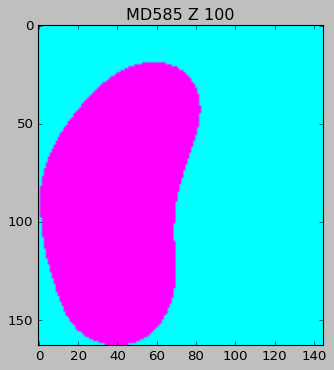

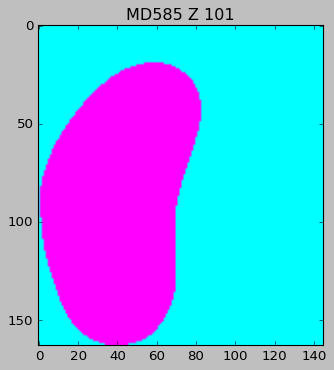

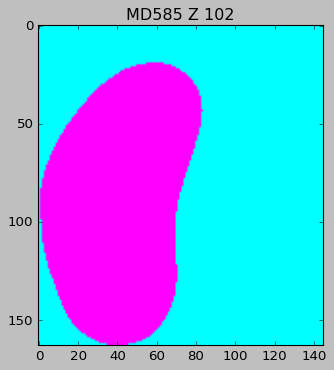

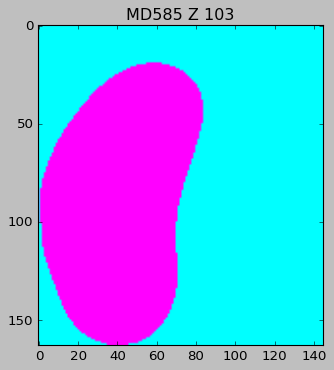

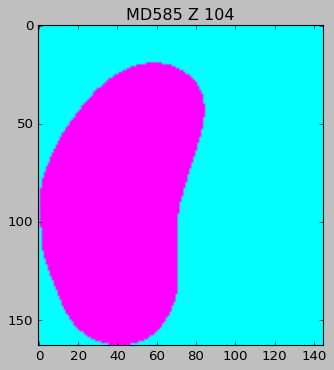

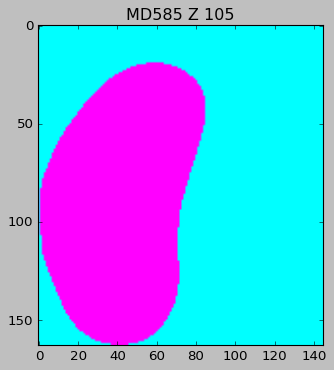

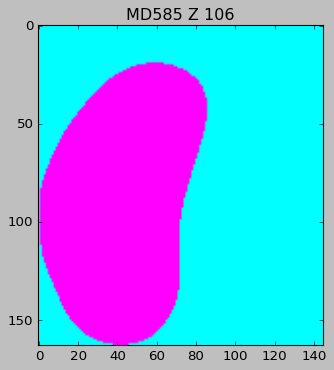

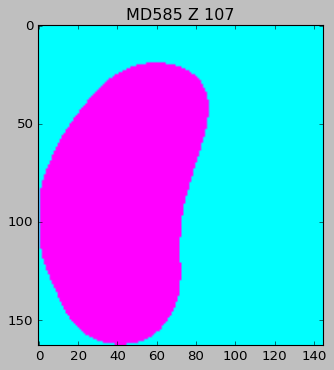

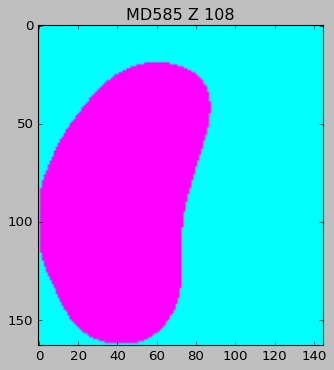

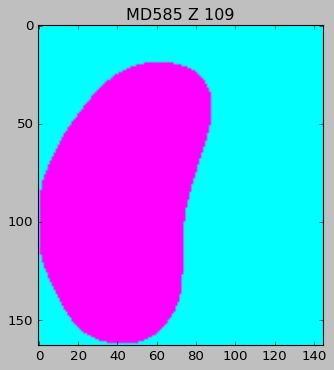

In [75]:
sc7 = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/atlasV7/structure/SC.npy'
sc8 = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/atlasV8/structure/SC.npy'
sc = np.load(sc8)
arr = sc.copy()

#arr = np.rot90(arr, axes=(0,1))
#arr = np.flip(arr, axis=0)
#arr[arr > 0.8] = 100
arr = arr.astype(np.uint8)


print(arr.shape, arr.dtype)
start = 100
end = start + 10
plt.style.use('classic')
plt.rcParams["figure.figsize"] = (8,5)
for i in range(start, end):
    plt.title('{} Z {}'.format(animal, i))
    plt.imshow(arr[:,:,i], cmap="cool")

    plt.show()

In [ ]:
DIR = '/net/birdstore/Active_Atlas_Data/data_root'
newpath = os.path.join(DIR, 'atlas_data/atlasV8/MD585/origin')
for structure in aligned_dict.keys():
    newfile = os.path.join(newpath, f'{structure}.txt')
    if not os.path.exists(newfile):
        print(newpath)
        continue
    origin = np.loadtxt(newfile)
    x, y, z = origin
    print(structure, round(x*(10)), round(y*10), round(z*10) )
